### Script to overlay AOD-500nmTotal and Wind Vector on the same plot.

### Make sure both the AERONET and Wind data files are in the right place and the Start and End Dates are within the dataset you're looking at.

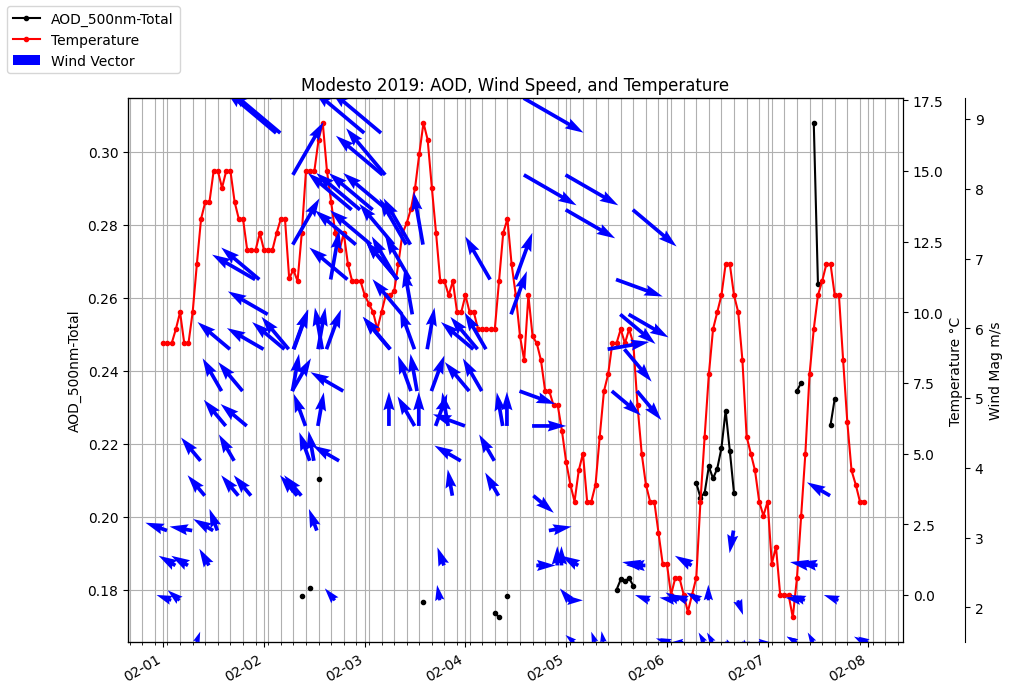

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

filename = 'AERONET_Data/20190101_20191231_Modesto.tot_lev20'
windfile = 'Wind_Data/Modesto_Wind_2019_Jan_Dec_72492623258.csv'
weatherFile = 'Wind_Data/Modesto_Weather_Feb_2019.csv'
StartDate='2019-02-01 00:00:00'
EndDate='2019-02-07 23:59:59'

# Load the AERONET data and make US/PAC time its index.
df = pd.read_csv(filename,skiprows = 6, parse_dates={'datetime':[0,1]})
datetime_utc=pd.to_datetime(df["datetime"], format='%d:%m:%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df.set_index(datetime_pac, inplace = True)

# Set the Columns that has the AOD Total and replace -999 with nan in visible wavelengths.
AODTotalColumns=range(3,173,8)
#for iWaveLength in df.columns[AODTotalColumns]: print(iWaveLength)
#Replaces all -999 values with nan so invalid entries does not affect resample.mean()

df['AOD_380nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_440nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_500nm-Total'].replace(-999.0, np.nan, inplace = True)
df['AOD_675nm-Total'].replace(-999.0, np.nan, inplace = True)
    
# Load NOAA data and make US/PAC time its index.
# Wdf = Weather Data Frame
Wdf = pd.read_csv(windfile, parse_dates={'datetime':[1]}, low_memory=False)
datetime_utc=pd.to_datetime(Wdf["datetime"], format='%d-%m-%Y %H:%M:%S')
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
Wdf.set_index(datetime_pac, inplace = True)
# Note that we're making a copy of Wdf as WNDdf (Wind Dataframe)
WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
## Cut on the Data that has both Valid Windspeed and Direction.
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf= WNDdf.loc[WNDdf[1]=='5']
Tdf = Wdf.loc[StartDate:EndDate,'TMP'].str.split(pat=',', expand = True)

Tdf.replace('+9999', np.nan, inplace = True)
#Tdf.replace('+', '0', inplace = True)
#print(Tdf)
#print(WNDdf)
#plt.figure(figsize=(10,8))  
fig, ax = plt.subplots(figsize=(10,8))
#fig.subplots_adjust(right=0.75)
plt.title("Modesto 2019: AOD, Wind Speed, and Temperature")
plt.grid(which='both',axis='both')

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plot1 = ax.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'ok-',label='AOD_500nm-Total')
#plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'.k-',label='AOD_500nm-Total')
ax.set_ylabel("AOD_500nm-Total")
#fig.legend(loc ='upper left')
#legend1 = plt.legend()

ax3 = ax.twinx()
ax3.spines.right.set_position(('axes', 1))
#ax3.set_ylim(Tdf[0].loc[StartDate:EndDate].astype(float).min(), Tdf[0].loc[StartDate:EndDate].astype(float).max())
plot3 = ax3.plot(Tdf[0].loc[StartDate:EndDate].astype(float).resample('1h').mean().div(10), '.r-',label='Temperature')
ax3.set_ylabel('Temperature °C')
#fig.legend(loc = 'upper right')

ax2 = ax.twinx()
ax2.spines.right.set_position(('axes', 1.08))
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Wind Mag m/s")
#### Converting from Cartesian to Cardinal direction requires that we flip the vector calculated
#### As noted with the - sign for the dx and dy calculations.
ax2.set_ylim(WNDdf[3].loc[StartDate:EndDate].astype(float).div(10).min(), WNDdf[3].loc[StartDate:EndDate].astype(float).div(10).max())
#ax2.set_ylim(0,8)
plot2 = ax2.quiver( WNDdf.index,
            WNDdf[3].loc[StartDate:EndDate].astype(float).div(10),
            -WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)
           *np.sin((WNDdf[0].loc[StartDate:EndDate].astype(float))*np.pi/180.),
            -WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)
           *np.cos((WNDdf[0].loc[StartDate:EndDate].astype(float))*np.pi/180.),
            color='b',label='Wind Vector')
#fig.legend(loc ='upper right')
#legend2 = ax2.legend()

#print(plot1.label)
#print(plot2.get_label())
#print(plot3.get_label())
#plt.legend(handles = [ax, ax2, ax3])
fig.legend(loc = 'upper left')

filename = 'Modesto_'# + StartDate + '_' + EndDate
location = 'graphs\\Modesto 2019\\' + filename
plt.savefig(location) # Saves the plot to a .png file.

plt.show()

'https://matplotlib.org/3.4.3/gallery/ticks_and_spines/multiple_yaxis_with_spines.html' # ← Use this format for graph handling

print()

### Let's open the Turlock AOD 1.5 Data. The 1.5 does not have a quality check on them compared to 2.0.

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

filename = 'AERONET_Data/20230101_20231231_Turlock_CA_USA.tot_lev15'

# Load Files 
df = pd.read_csv(filename,skiprows = 6, parse_dates={'datetime':[0,1]})
datetime_utc=pd.to_datetime(df["datetime"], format='%d:%m:%Y %H:%M:%S')
#print(datetime_pac.head())
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
#print(datetime_pac.head())

df.set_index(datetime_pac, inplace = True)
df.replace(-999.0, np.nan, inplace = True)
#print(df.head())  

AODTotalColumns=range(3,173,8)
for iWaveLength in df.columns[AODTotalColumns]: print(iWaveLength) #Print out the List of Wavelength with AOD Total


AOD_1640nm-Total
AOD_1020nm-Total
AOD_870nm-Total
AOD_865nm-Total
AOD_779nm-Total
AOD_675nm-Total
AOD_667nm-Total
AOD_620nm-Total
AOD_560nm-Total
AOD_555nm-Total
AOD_551nm-Total
AOD_532nm-Total
AOD_531nm-Total
AOD_510nm-Total
AOD_500nm-Total
AOD_490nm-Total
AOD_443nm-Total
AOD_440nm-Total
AOD_412nm-Total
AOD_400nm-Total
AOD_380nm-Total
AOD_340nm-Total


### Now let's make a plot of all the AOD Total for Different Wavelengths.

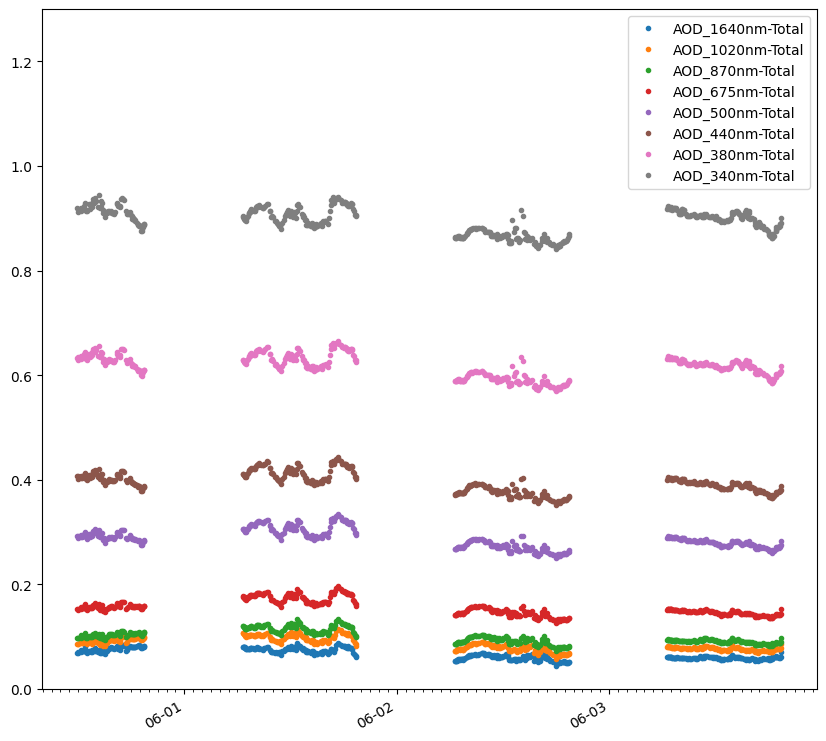

In [16]:
plt.figure(figsize=(10,10))   
#df[80:130]
for iWaveLength in df.columns[AODTotalColumns]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df[iWaveLength][0:494],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0,1.3)
plt.legend()
plt.show()


### There doesn't seem to be a big dependency on the wavelengths. So let's focus on the visible range only.

#### The reason that the minor and major locator tick does not line is up due to a bug since Python 3.5.2 where the HourLocator cannot do timezone correction. So its actually ploting those 3 hours tick marks in UTC. Due to the 7 hours time zone difference, it results in an 1 hour difference in the placement of the hourly tick mark relative to the Day (midnight) mark.

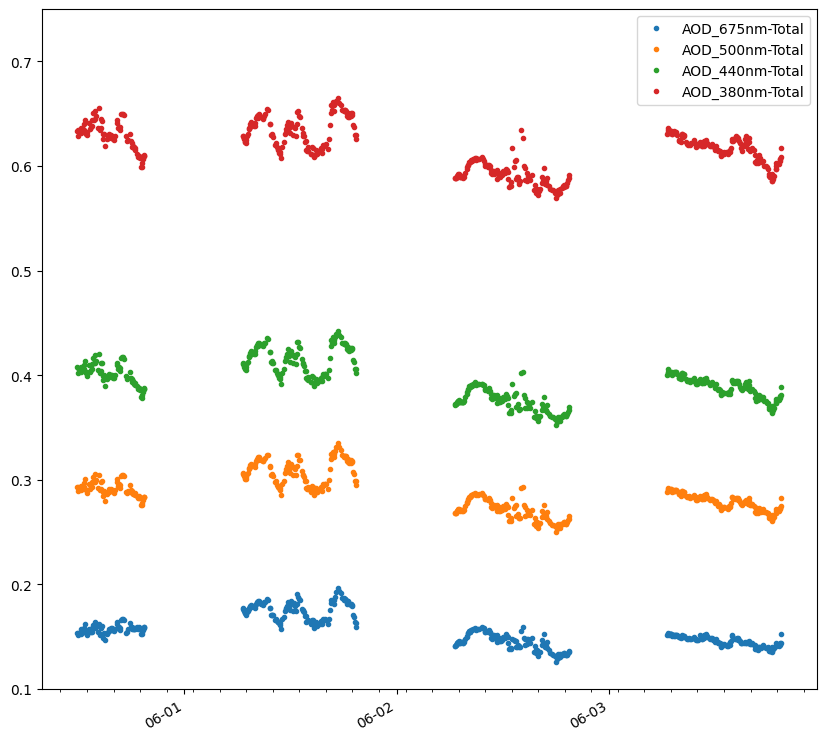

In [17]:
plt.figure(figsize=(10,10))  
# AODTotalColumns[5] is 675nm, AODTotalColumns[-1-1] is 380nm
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df[iWaveLength][0:494],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.ylim(0.1,0.75)
plt.legend()
plt.show()

### Now, let's pick a starting time and ending time instead of the DF's index to cut on the plot.

#### This plot has some interesting uptake on the AOD on June 6th and 7th.

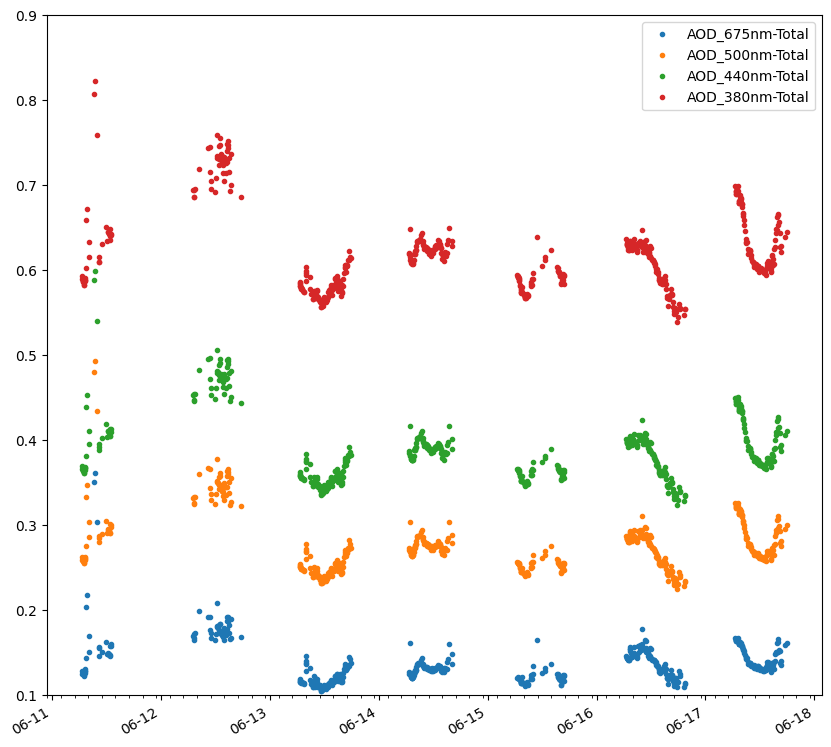

In [18]:
StartDate='2023-06-10'
EndDate='2023-06-17'

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength])
        plt.plot(df.loc[StartDate:EndDate,iWaveLength],'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.9)
plt.legend()
plt.show()

### Now let's do an hourly average of the data.

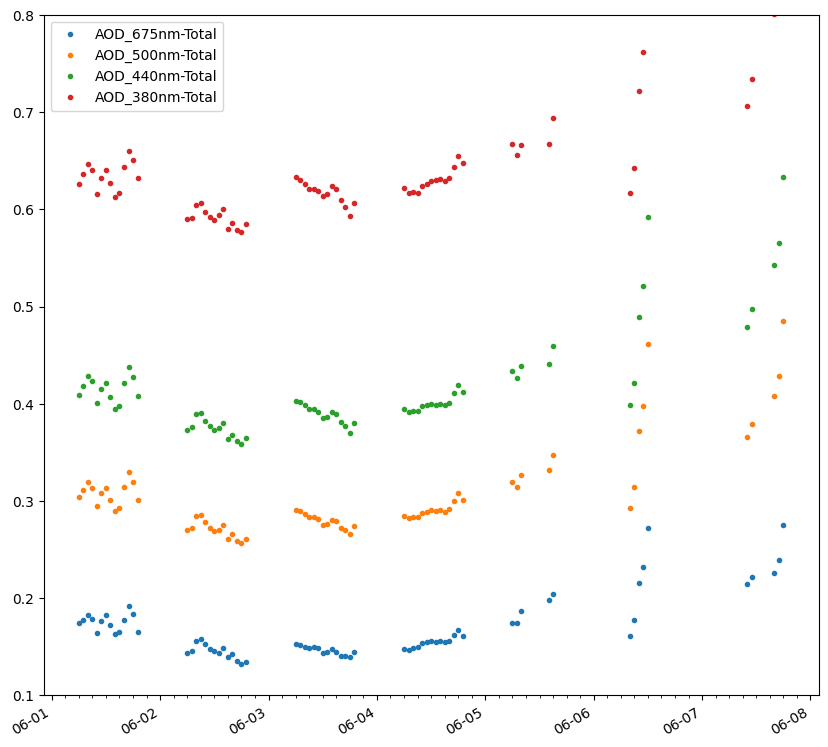

In [19]:
StartDate='2023-06-01'
EndDate='2023-06-07'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[5:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('1h').mean(),'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.8)
plt.legend()
plt.show()


### Repeat for 3 Hour Averaging.

#### Note that now we're at the point where we have 5 data points some days, 4 or 3 depending on how long the instrument takes data for. This is fairly annoying to fix and Anthony already did it so I will move on to Daily Averages.

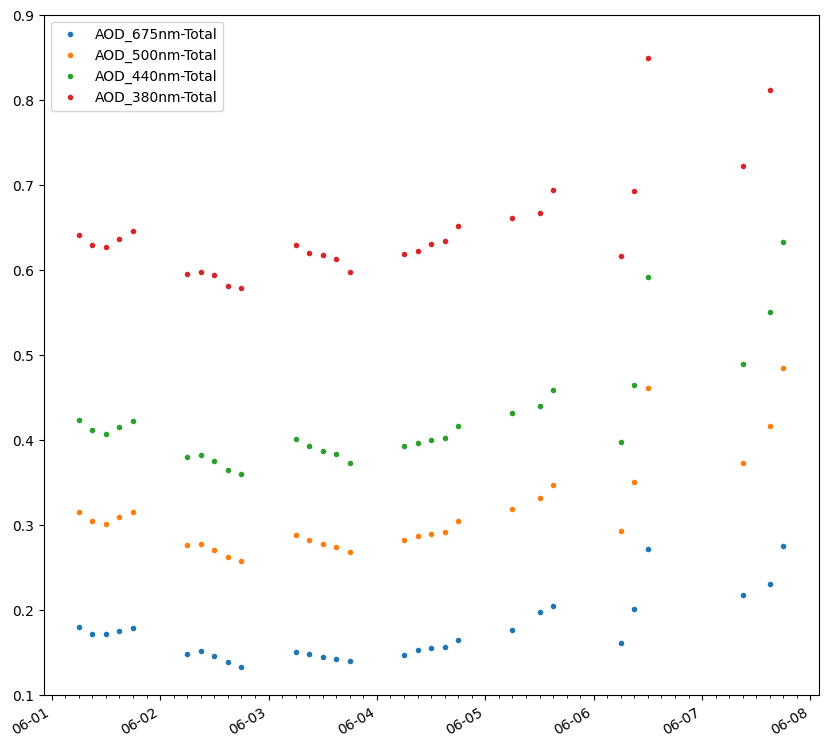

In [20]:
StartDate='2023-06-01 07:00:00'
EndDate='2023-06-07 19:00:00'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[3:-1]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('3h', ).mean(),'.',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.1,0.9)
plt.legend()
plt.show()


### Plotting the Daily averages for the entire 1.3 Months.

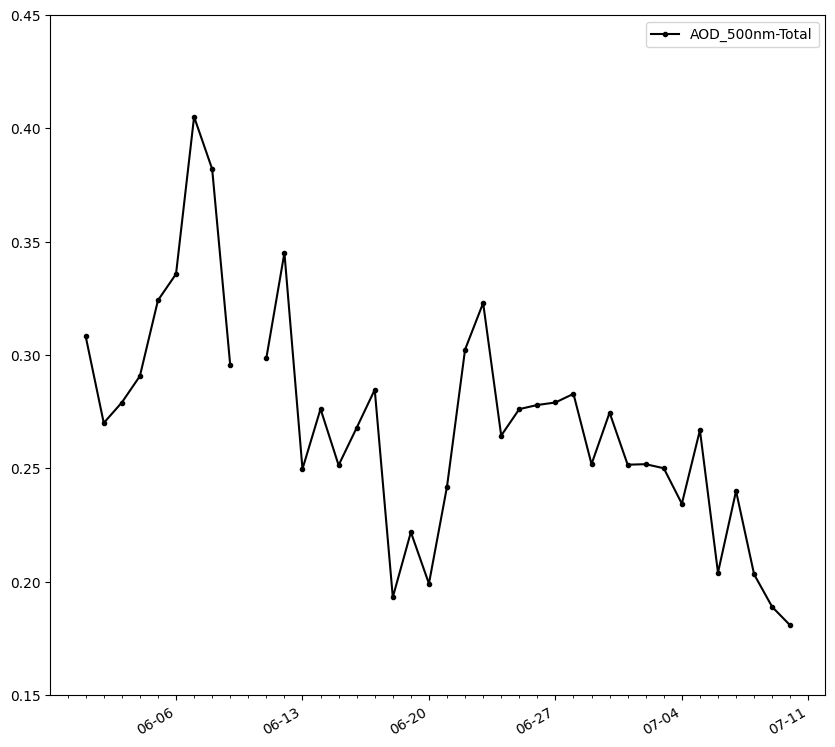

In [21]:
StartDate='2023-06-01'
EndDate='2023-07-10'

plt.figure(figsize=(10,10))  
for iWaveLength in df.columns[AODTotalColumns[6:-5]]: 
    if(df[iWaveLength].mean() > 0):
        #print(iWaveLength)
        plt.plot(df.loc[StartDate:EndDate,iWaveLength].resample('1D', ).mean(),'.-k',label=iWaveLength)
        #plt.plot(df[iWaveLength][0:94],'.',label=iWaveLength)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ylim(0.15,0.45)
plt.legend()
plt.show()


### Let's look at the Wind Data for June 2023, starting with the magnitude only.

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

windfile = 'Wind_Data/Modesto_Wind_2023.csv'

# Load Files 
Wdf = pd.read_csv(windfile, parse_dates={'datetime':[1]})
Wdf.head()

datetime_utc=pd.to_datetime(Wdf["datetime"], format='%d-%m-%Y %H:%M:%S')
#print(datetime_pac.head())
datetime_pac= pd.to_datetime(datetime_utc).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
#print(datetime_pac.head())

Wdf.set_index(datetime_pac, inplace = True)
#print(Wdf.head())  
print(Wdf['WND'].str.split(pat=',', expand= True))

                             0  1  2     3  4
datetime                                     
2022-12-31 16:15:00-08:00  260  5  N  0046  5
2022-12-31 16:22:00-08:00  260  5  N  0041  5
2022-12-31 16:27:00-08:00  260  5  N  0051  5
2022-12-31 16:34:00-08:00  270  5  N  0057  5
2022-12-31 16:53:00-08:00  260  5  N  0057  5
...                        ... .. ..   ... ..
2023-07-09 19:53:00-07:00  330  5  N  0051  5
2023-07-09 20:53:00-07:00  330  5  N  0051  5
2023-07-09 21:53:00-07:00  330  5  N  0051  5
2023-07-09 22:53:00-07:00  330  5  N  0046  5
2023-07-09 23:53:00-07:00  330  5  N  0041  5

[5480 rows x 5 columns]


### Let's start with 1 hour averaging for the week of June 1st to June 8th (Getting one more day before and after to see the trend after the week).

#### For May 31st to June 4th. The AOD seems to trend down in the afternoon. The wind usually picks up to about 6-7 m/s at about 3PM also.

#### For June 5th, we have a upward trend on the AOD even though the wind is picking up at the same time.

### For June 5th, 6th and 7th. There seems to be unreliable data. This is worth looking at one its own.

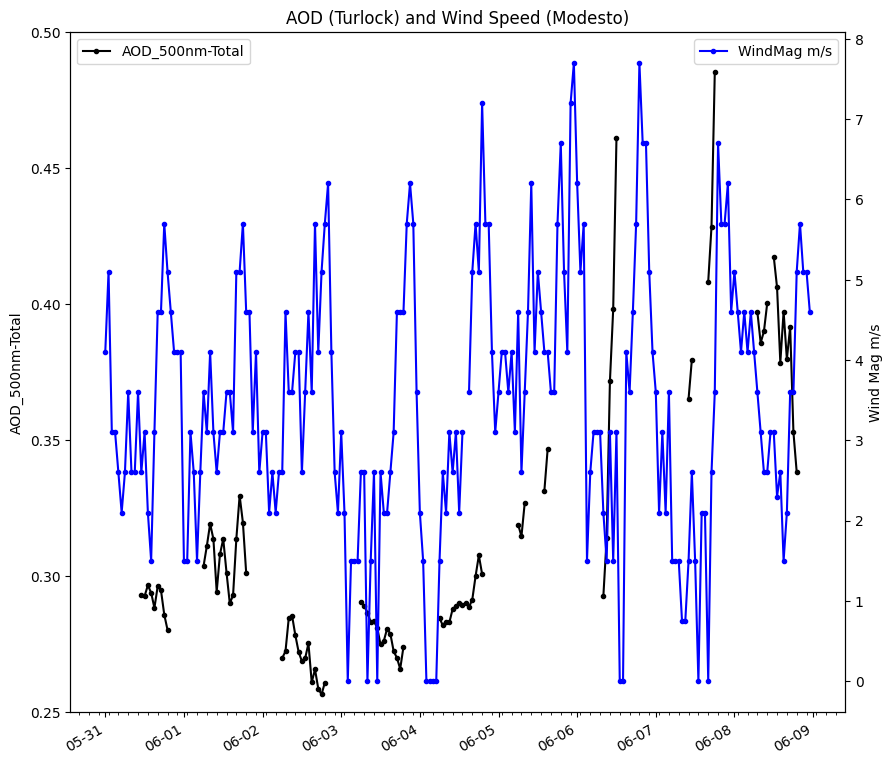

In [23]:

StartDate='2023-05-31 00:00:00'
EndDate='2023-06-08 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,10))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1h').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

### Let's look at the data from June 5th to 7 on its own.

#### Can't really see much with the 1h resampling. Let's remove the resampling...

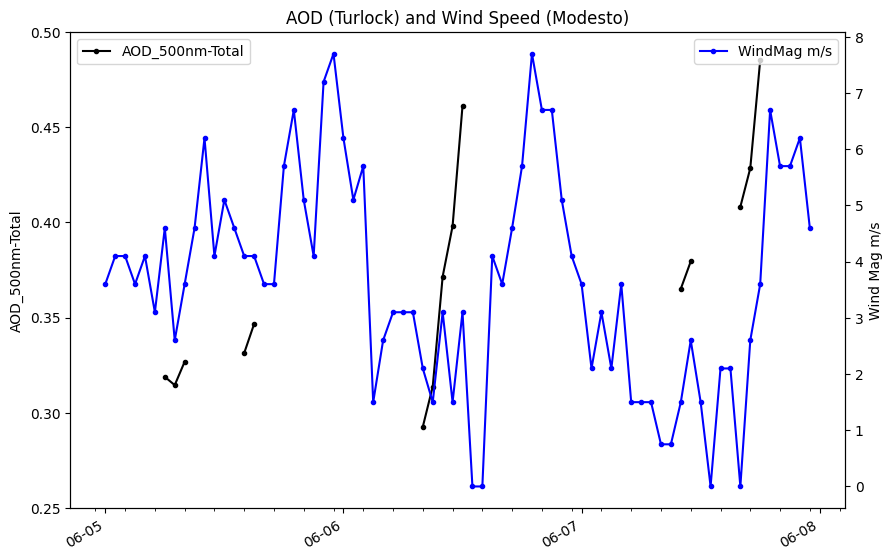

In [24]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-05 00:00:00'
EndDate='2023-06-07 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1h').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

### Let's look at the data from June 5th to 7 on its own without resampling


#### It looks like there are just time when the AOD data is missing
#### Its the same for the other wavelengths also.

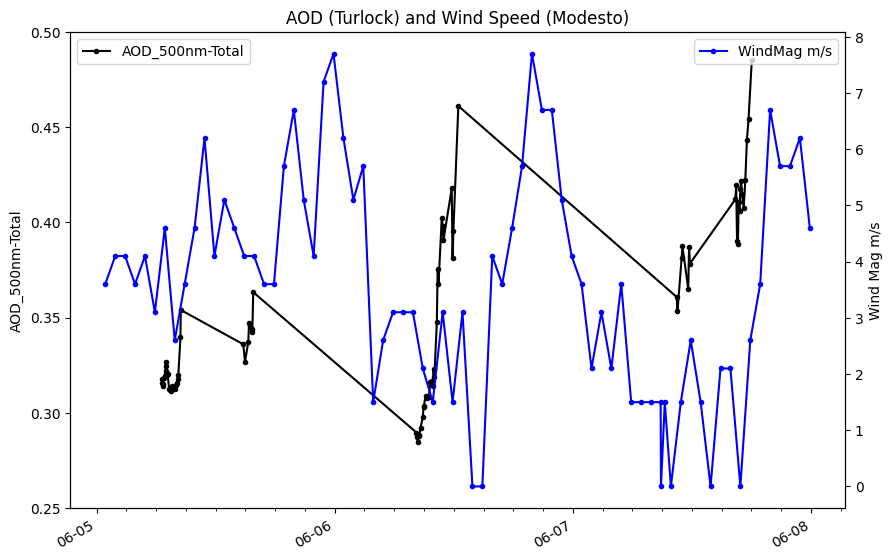

In [25]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-05 00:00:00'
EndDate='2023-06-07 23:59:59'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())

WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()

plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'],'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.title("AOD (Turlock) and Wind Speed (Modesto)")
plt.ylim(0.25,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot(WNDdf[3].loc[StartDate:EndDate].astype(float).div(10),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()

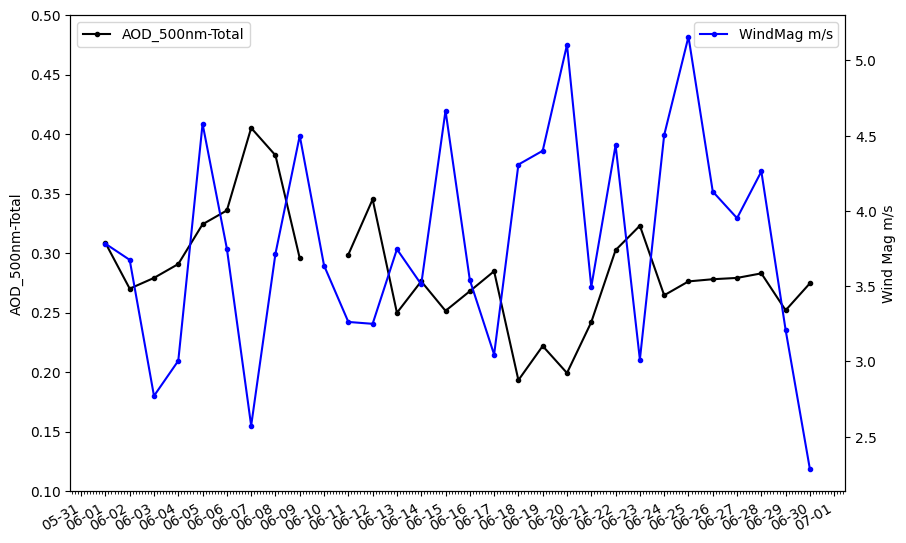

In [26]:
#print(df['WND'].str.split(pat=',', expand= True)[3])
StartDate='2023-06-01 07:00:00'
EndDate='2023-06-30 23:00:00'
#print(df.loc[StartDate:EndDate,'AOD_440nm-Total'].resample('1h').mean())


WNDdf= Wdf.loc[StartDate:EndDate,'WND'].str.split(pat=',', expand= True)
#print(WNDdf[4]==5)
WNDdf= WNDdf.loc[WNDdf[4]=='5']
WNDdf.head()


plt.figure(figsize=(10,7))  

plt.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('1D').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("AOD_500nm-Total")
plt.legend(loc ='upper left')
plt.ylim(0.1,0.5)
ax2 = plt.gca().twinx()
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz='US/Pacific'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=3, tz='US/Pacific'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.plot((WNDdf[3].loc[StartDate:EndDate].astype(float).div(10)).resample('1D').mean(),'.b-',label="WindMag m/s")
#ax2.plot(df.loc[StartDate:EndDate,'AOD_500nm-Total'].resample('2h').mean(),'.k-',label='AOD_500nm-Total')
plt.ylabel("Wind Mag m/s")
ax2.legend(loc ='upper right')
plt.show()